# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ";")

In [4]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ";")

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [7]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
def string_to_list(item):
    """
    converts string containing list to list of integers
    INPUT: String with list items
    RETURNS: List of integers based on INPUT
    """
    
    #removes brackets ([]) and splits remaining string into a list of strings
    x = item.strip("[]").split(",")
    
    #new list to be returned
    newList = []
    
    #if each item of x can be converted to an integer, append to new list. If not append original value
    for i in x:
        try: 
            i = int(i)
            newList.append(i)
        except: 
            newList.append(i)
            
    return newList

In [6]:
feat_info["NA_int"] = feat_info.loc[:,"missing_or_unknown"].apply(lambda x : string_to_list(x))

In [7]:
feat_info.drop('missing_or_unknown', axis = 1, inplace=True)
feat_info.set_index('attribute', inplace=True)

**Note**: Tried to do this with list comprehension, but get stuck on the items in the missing_or_unkonwn that are empty `['']`. Is this at all possible? Code as follows: 

```
df = feat_info.copy()
df["NA_int"] = 
[[int(str(idx if idx.isdigit() else '')) for idx in x.strip("[]").split(",")] for x in df.loc[:,"missing_or_unknown"]]

```
I was able to convert to string items with the following code, but was not able to convert this to integers after converting to strings. Code for converting to string as follows: 
```df["NA_Tags"] = [x.strip("[]").split(",") for x in df.loc[:,"missing_or_unknown"]]```

In [84]:
#missing values in original dataset
original_NaNs = azdias.isna().sum().sum()
print("Missing values in the original dataset: {} entries".format(original_NaNs))

Missing values in the original dataset: 4896838 entries


In [231]:
azdias_nan = azdias.copy()

In [232]:
for column in azdias_nan.columns:
    azdias_nan.loc[azdias_nan.loc[:,column].isin(feat_info.loc[column, 'NA_int']), column] = np.nan

In [236]:
#saving for future sessions
azdias_nan.to_csv('azdias_nan.csv')

In [10]:
azdias_nan = pd.read_csv('azdias_nan.csv')
azdias_nan.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [239]:
updated_NaNs = azdias_nan.isna().sum().sum()
print("Missing values in the updated dataset: {} entries".format(updated_NaNs))
print("Additional missing values converted: {}".format(updated_NaNs - original_NaNs))

Missing values in the updated dataset: 8373929 entries
Additional missing values converted: 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
def df_completeness(df, threshold):
    """
    Plots the data completeness of a dataframe, sorted ascending by completeness. Features below theshold are highlighted. 
    
    INPUTS
    df: dataframe to be plotted 
    threshold: threshold of features to be highlighted
    
    RETURNS
    cols_below_thresh: list of column names in df below threshold
    """
    
    plot=(df.count()/len(df)*100).sort_values(ascending=True)
    
    outliers = len(plot[plot<threshold])
    
    plt.figure(figsize=(6, 16))
    p=sns.barplot(x=plot, y=plot.index, palette='viridis')
    p.set(xlabel="percentage",ylabel="features", title="Dataset completeness")
    p.set_xticklabels(p.get_xticklabels(), rotation=90)
    
    for i in range(0,outliers):
        p.patches[i].set_color("red")    
    
    print((df.count()-len(df)).apply(lambda x: "100% Complete" if x == 0 else "Missing "+str(x).split("-")[1]+" data points"))
    
    cols_below_thresh = list(plot[plot<threshold].index)
    
    print("\n\n {} columns below threshold:\n".format(len(cols_below_thresh)))
    for c in cols_below_thresh:
        print("- {}".format(c))
    
    return cols_below_thresh

AGER_TYP                 Missing 685843 data points
ALTERSKATEGORIE_GROB       Missing 2881 data points
ANREDE_KZ                             100% Complete
CJT_GESAMTTYP              Missing 4854 data points
FINANZ_MINIMALIST                     100% Complete
FINANZ_SPARER                         100% Complete
FINANZ_VORSORGER                      100% Complete
FINANZ_ANLEGER                        100% Complete
FINANZ_UNAUFFAELLIGER                 100% Complete
FINANZ_HAUSBAUER                      100% Complete
FINANZTYP                             100% Complete
GEBURTSJAHR              Missing 392318 data points
GFK_URLAUBERTYP            Missing 4854 data points
GREEN_AVANTGARDE                      100% Complete
HEALTH_TYP               Missing 111196 data points
LP_LEBENSPHASE_FEIN       Missing 97632 data points
LP_LEBENSPHASE_GROB       Missing 94572 data points
LP_FAMILIE_FEIN           Missing 77792 data points
LP_FAMILIE_GROB           Missing 77792 data points
LP_STATUS_FE

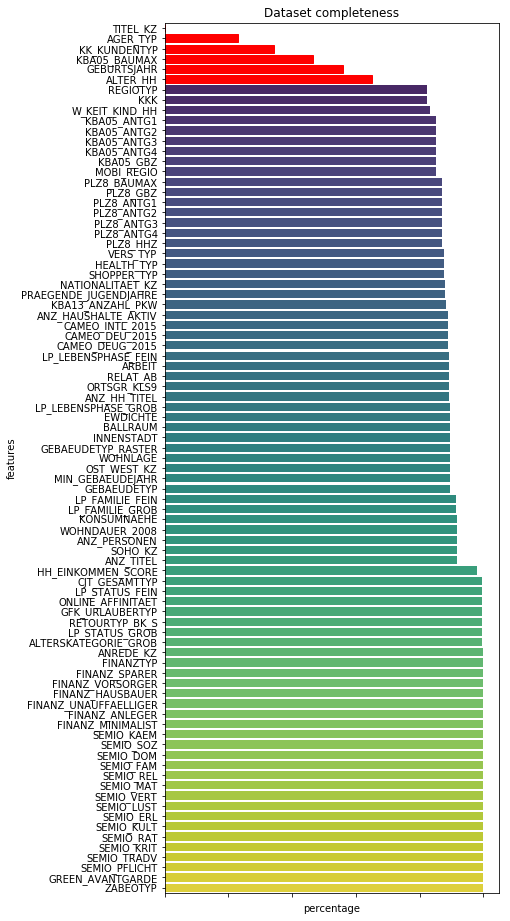

In [12]:
# Investigate patterns in the amount of missing data in each column.

#setting a threshold of 80 % compleness: 
cols_to_drop = df_completeness(azdias_nan, 80)

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_nan.drop(columns=cols_to_drop, axis=1, inplace=True) 

#### Discussion 1.1.2: Assess Missing Data in Each Column

We see above the missing data per colums. By setting a threshold of 80% completeness, we will remove the following columns: 
```
- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH
```

We also see that in general rows related to `KBA05_` and `PLZ08_` in general are missing a significant portion of data. If these are related to specific regions, there is a chance for slightly skewed data.

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [93]:
# How much data is missing in each row of the dataset?
complete_rows = len(azdias_nan.dropna())
complete_ratio = complete_rows / len(azdias_nan)
print("There are {} rows without any missing data. This is {} % of total rows".format(
    complete_rows, complete_ratio*100))
print("Rows with missing data are spread accross {} % of total rows".format((1-complete_ratio)*100))

There are 623209 rows without any missing data. This is 69.9275488346886 % of total rows
Rows with missing data are spread accross 30.07245116531141 % of total rows


In [53]:
df_miss = azdias_nan.copy()
df_miss["Missing_features"] = df_miss.isna().sum(axis=1)

(array([  6.66873000e+05,   3.02360000e+04,   5.00000000e+04,
          2.76340000e+04,   7.30300000e+03,   5.49800000e+03,
          7.92500000e+03,   1.60800000e+03,   6.28000000e+02,
          2.01000000e+02,   1.14000000e+02,   4.10000000e+01,
          9.00000000e+00,   1.40070000e+04,   3.99500000e+03,
          1.03600000e+03,   4.93000000e+02,   2.75450000e+04,
          4.94000000e+02,   4.55810000e+04]),
 array([  0.  ,   2.45,   4.9 ,   7.35,   9.8 ,  12.25,  14.7 ,  17.15,
         19.6 ,  22.05,  24.5 ,  26.95,  29.4 ,  31.85,  34.3 ,  36.75,
         39.2 ,  41.65,  44.1 ,  46.55,  49.  ]),
 <a list of 20 Patch objects>)

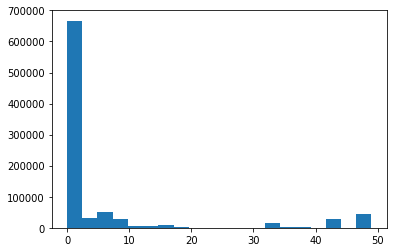

In [54]:
plt.hist(df_miss["Missing_features"], bins = 20)

In [55]:
df_miss["Missing_features"].value_counts()

0     623209
47     45578
2      27926
43     27369
8      24592
5      22515
3      17629
1      15738
6      13771
7      13714
4      12607
34     10816
10      5410
15      4743
35      3911
13      3255
9       3042
33      2985
16      2505
14      2243
19      1180
11      1127
12       766
17       677
37       538
45       494
18       428
38       421
41       356
20       349
32       206
44       155
21       150
40       137
23       132
22       129
36        84
39        77
24        69
26        59
25        55
27        24
42        21
29        12
30         6
28         5
31         3
49         2
48         1
Name: Missing_features, dtype: int64

In [86]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

We see above that there is a significant amount of rows that have more than 20 missing features. 
Checking if their distribution is different from the rest of the dataset:

In [90]:
def compare_columns(df, column, threshold):
    """
    Divides dataset by column 'Missing_features' on above/below threshold. 
    Plots the distribution for each dataset
    """
    
    #splitting dataset
    df_a = df_miss.loc[df_miss.loc[:, "Missing_features"]<=threshold, column]
    df_b = df_miss.loc[df_miss.loc[:, "Missing_features"]>threshold, column]
    
    #plotting
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    sns.countplot(df_a,ax=ax1)
    sns.countplot(df_b,ax=ax2)
    plt.tight_layout()                        

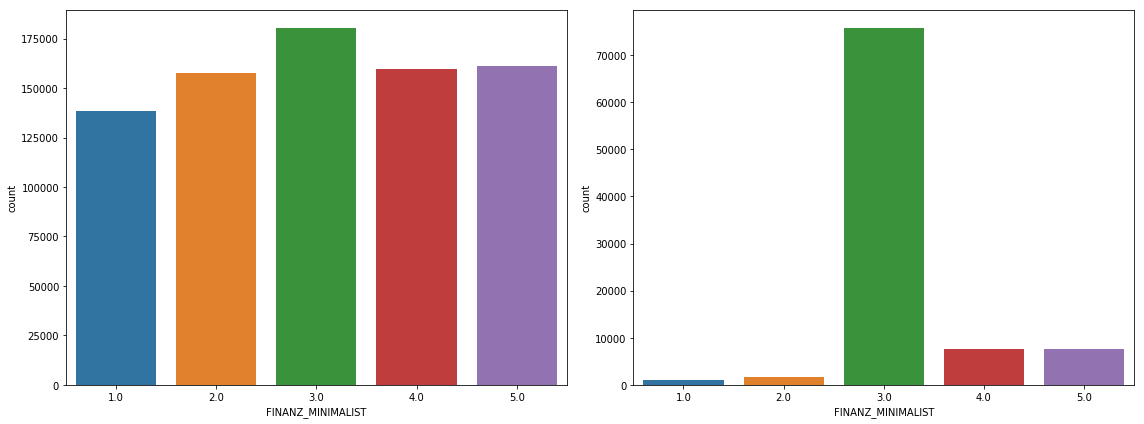

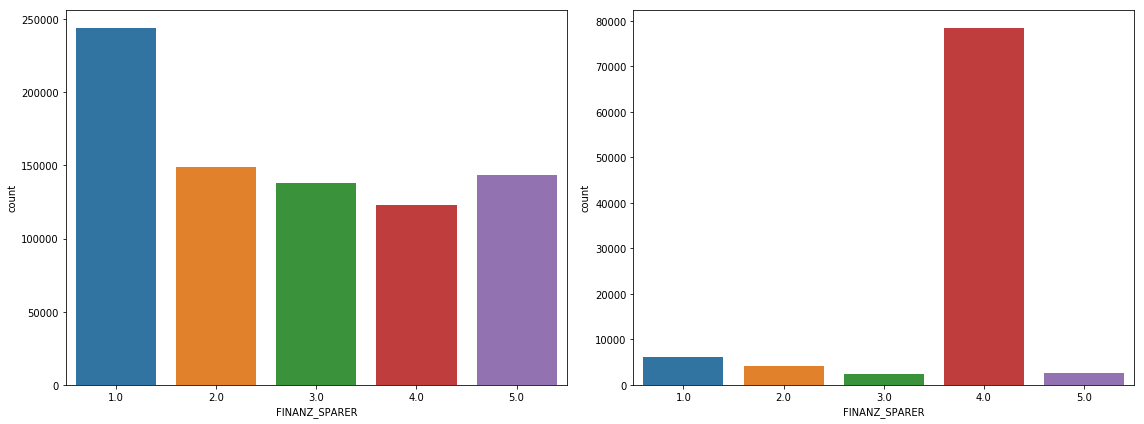

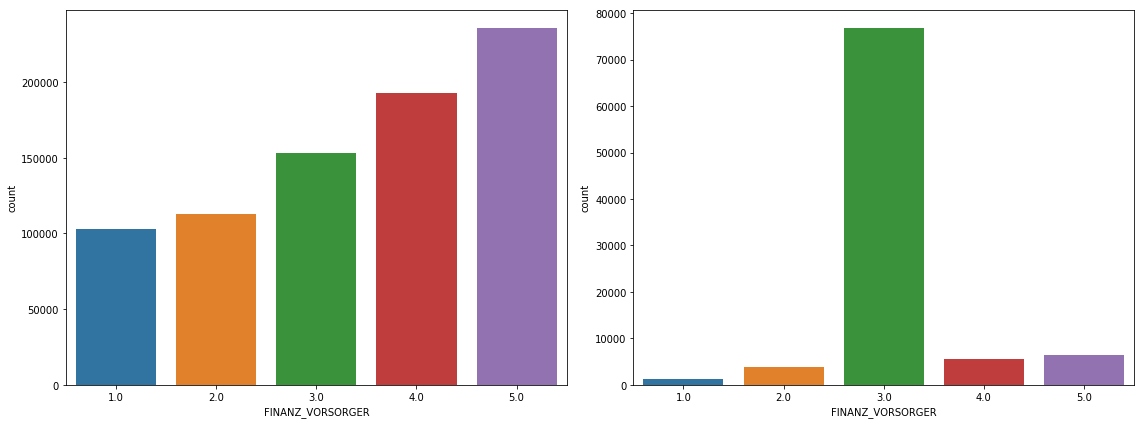

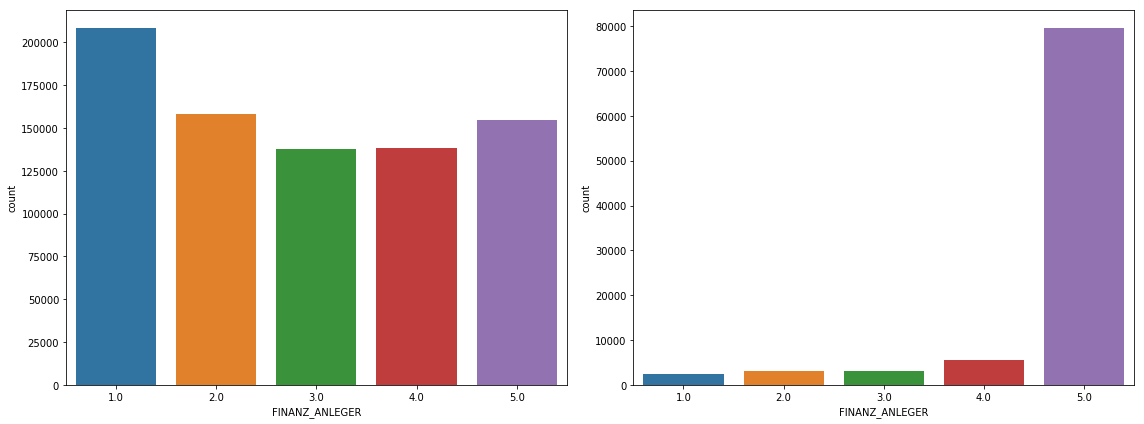

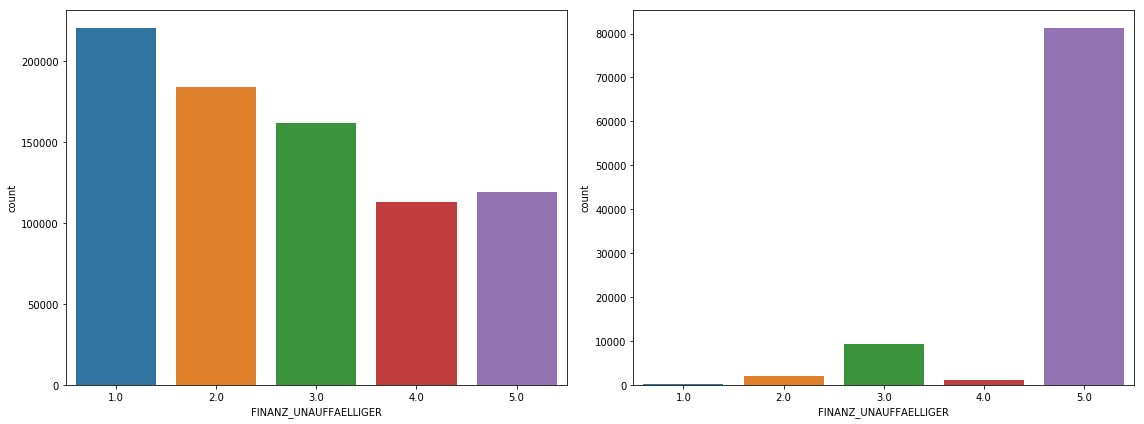

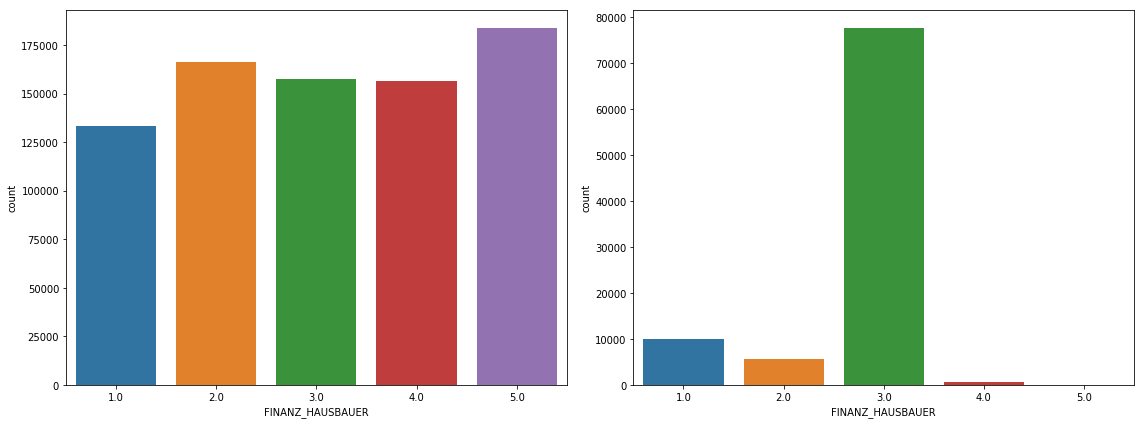

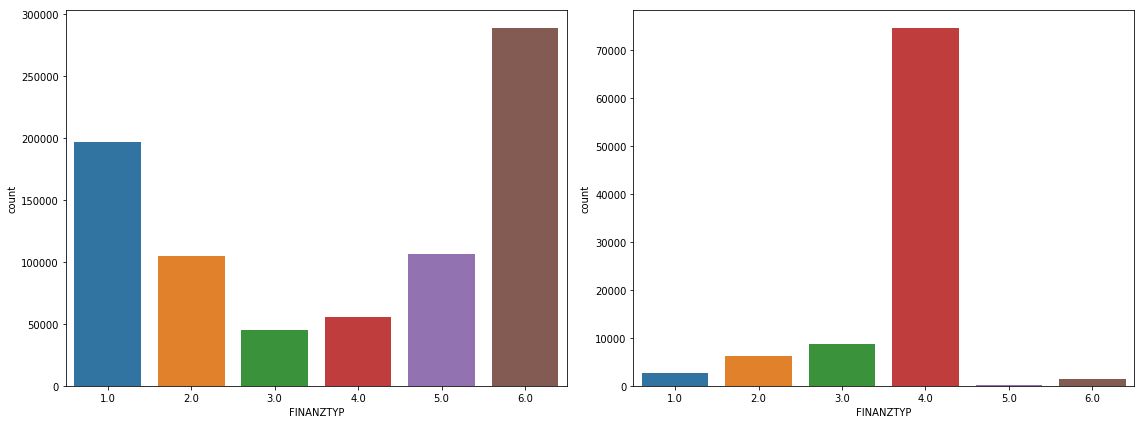

In [92]:
cols_to_compare = ['FINANZ_MINIMALIST', 
                   'FINANZ_SPARER', 
                   'FINANZ_VORSORGER',
                   'FINANZ_ANLEGER', 
                   'FINANZ_UNAUFFAELLIGER', 
                   'FINANZ_HAUSBAUER','FINANZTYP']

for c in cols_to_compare:
    compare_columns(df_miss, c, 20)

Performing an additional analysis on all columns: 

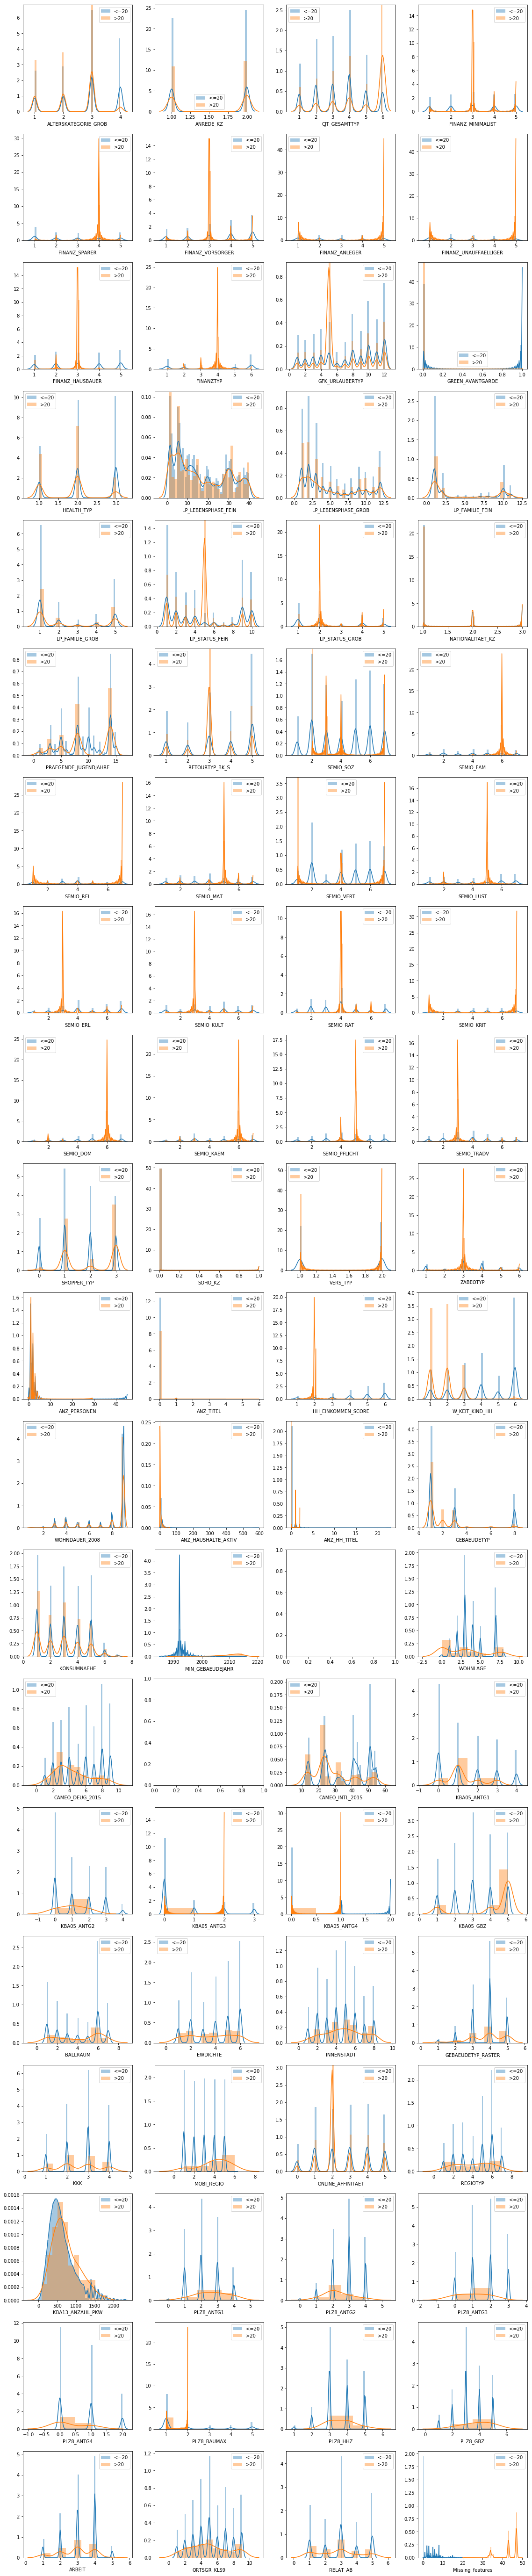

In [82]:
plt.figure(figsize=(16,80))

for i,column in enumerate(df_miss.columns):
    plt.subplot(21, 4,i+1)
    try:
        sns.distplot(df_miss.loc[df_miss.loc[:, "Missing_features"]<=20, column].dropna(), label="<=20")
        sns.distplot(df_miss.loc[df_miss.loc[:, "Missing_features"]>20, column].dropna(), label=">20")
    except: 
        pass
    plt.legend()
    
plt.tight_layout()
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row
We see that rows with missing data are spred accorss about 30% of the dataset. 

We did an additional inspection on rows that were missing data in more than 20 features, and we inspected the financial related features. We see a significant difference in how the data is distributed between the rows with little missing data and the rows with more missing data. 

We did an additional analysis accross all columns, and we also see similar difference in distribution regarding social topologies (by looking at the spikes in the `SEMIO_X` columns). Similar observations also apply to `green_avantgarde`, `lp_status_X`, and `retourtyp_BK_S`. 

These findings might mean some skrew in the dataset related to certain groups of people missing data values. Social  and financial topologies are likely related, and so are probably "Membership in environmental sustainability as part of youth" (or lack of) and social status. 

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [13]:
# How many features are there of each data type?
feat_info["type"].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [71]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded? 
feat_info_c = feat_info.loc[(feat_info.loc[:,'type']=="categorical") & (~feat_info.index.isin(cols_to_drop)), :].copy()
feat_info_c["Cat_values"] = None

In [72]:
for c in list(feat_info_c.index):
    try:
        val = list(azdias_nan.loc[:,c].dropna().unique())
        feat_info_c.loc[c,"Cat_values"] = val
    except Exception as e:
        feat_info_c.loc[c,"Cat_values"] = "N/A"
        print(e)
feat_info_c

,information_level,type,NA_int,Cat_values
attribute,,,,
ANREDE_KZ,person,categorical,"[-1, 0]","[1.0, 2.0]"
CJT_GESAMTTYP,person,categorical,[0],"[2.0, 5.0, 3.0, 4.0, 1.0, 6.0]"
FINANZTYP,person,categorical,[-1],"[4.0, 1.0, 6.0, 5.0, 2.0, 3.0]"
GFK_URLAUBERTYP,person,categorical,[],"[10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4...."
GREEN_AVANTGARDE,person,categorical,[],"[0.0, 1.0]"
LP_FAMILIE_FEIN,person,categorical,[0],"[2.0, 5.0, 1.0, 10.0, 7.0, 11.0, 3.0, 8.0, 4.0..."
LP_FAMILIE_GROB,person,categorical,[0],"[2.0, 3.0, 1.0, 5.0, 4.0]"
LP_STATUS_FEIN,person,categorical,[0],"[1.0, 2.0, 3.0, 9.0, 4.0, 10.0, 5.0, 8.0, 6.0,..."
LP_STATUS_GROB,person,categorical,[0],"[1.0, 2.0, 4.0, 5.0, 3.0]"


In [106]:
azdias_nan.loc[:,"OST_WEST_KZ"] = azdias_nan.loc[:,"OST_WEST_KZ"].dropna().apply(lambda x: 0 if x == "W" else 1)
azdias_nan["OST_WEST_KZ"].value_counts()

0.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64

In [115]:
feat_info_c.index

Index(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP',
       'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ',
       'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'],
      dtype='object', name='attribute')

In [287]:
# Re-encode categorical variable(s) to be kept in the analysis.
multi_cols_to_drop = ['LP_FAMILIE_GROB','LP_STATUS_GROB']
multi_cols_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
                     'LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'NATIONALITAET_KZ', 
                     'SHOPPER_TYP','ZABEOTYP', 'GEBAEUDETYP','CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

#### Discussion 1.2.1: Re-Encode Categorical Features

The `OST_WEST_KZ` column is convered to binary values `[0,1]` through a lambda expression.  

Columns `['LP_FAMILIE_GROB','LP_STATUS_GROB']` are dropped as we have more granular verions of these features in `..._FEIN`.

The following columns are converted to dummy-variables throgh pandas.get_dummies():
`['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN', 'NATIONALITAET_KZ','SHOPPER_TYP','ZABEOTYP', 'GEBAEUDETYP','CAMEO_DEUG_2015', 'CAMEO_DEU_2015']`

Originally I would prefer to use One Hot Encoding since this will allow us to reuse the encoder for new data with more stability ([1](https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki)). However, for this I need to convert strings to numeric values with OrdinalEncoder() which is not available in this version of scikit Learn ([2](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features)). 

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [227]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_nan["decade"], azdias_nan["dom_movement"] = None, None

In [228]:
dec_vals = []
movement_vals = []

praegende_jugendjahre_dict = {
    1: [40, 0], 
    2: [40, 1], 
    3: [50, 0], 
    4: [50, 1], 
    5: [60, 0], 
    6: [60, 1],
    7: [60, 1],
    8: [70, 0], 
    9: [70, 1], 
    10: [80, 0], 
    11: [80, 1], 
    12: [80, 0], 
    13: [80, 1], 
    14: [90, 0], 
    15: [90, 1]
}

In [229]:
for v in azdias_nan.loc[:,"PRAEGENDE_JUGENDJAHRE"]:
    try:
        dec_vals.append(praegende_jugendjahre_dict[v][0])
        movement_vals.append(praegende_jugendjahre_dict[v][1])
    except Exception as e:
        dec_vals.append(np.nan)
        movement_vals.append(np.nan)

In [372]:
azdias_nan.loc[:,"decade"] = dec_vals
azdias_nan.loc[:,"dom_movement"] = movement_vals

In [400]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_vals = []
life_stage_vals = []

for v in azdias_nan["CAMEO_INTL_2015"]:
    try: 
        wealth_vals.append(int(v/10))
        life_stage_vals.append(int(v%10))
    except: 
        wealth_vals.append(np.nan)
        life_stage_vals.append(np.nan)

In [402]:
azdias_nan["wealth"], azdias_nan["life_stage"] = None, None
azdias_nan.loc[:,"wealth"] = wealth_vals
azdias_nan.loc[:,"life_stage"] = life_stage_vals

In [262]:
feat_info.loc[feat_info.loc[:,"type"]=="mixed",:]

,information_level,type,NA_int
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [288]:
multi_cols_encode.extend(['WOHNLAGE','PLZ8_BAUMAX'])
multi_cols_to_drop.extend(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB','PRAEGENDE_JUGENDJAHRE', 
                           'CAMEO_INTL_2015'])

In [289]:
print(multi_cols_encode)
print(multi_cols_to_drop)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'WOHNLAGE', 'PLZ8_BAUMAX']
['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']


In [389]:
azdias_nan_enc = pd.get_dummies(azdias_nan, prefix=multi_cols_encode, columns=multi_cols_encode)
azdias_nan_enc.drop(multi_cols_to_drop, axis=1, inplace=True)

In [291]:
azdias_nan_enc.to_csv('azdias_nan_enc.csv')

#### Discussion 1.2.2: Engineer Mixed-Type Features

Features `'CAMEO_INTL_2015'` and `'PRAEGENDE_JUGENDJAHRE'` have been re-engineered and dropped from the dataset. 

In addition, the following featues are analyzed: 

- `'LP_LEBENSPHASE_FEIN'` and `'LP_LEBENSPHASE_GROB'` will be dropped. These are combination features including family, age, wealth, and life situation. This is captured elsewhere in the dataset. 
- `WOHNLAGE'` will be included as a categorical value as this is a categorical value explaining neighbourhood quality.
- `PLZ8_BAUMAX` willbe included as a categorical value as this explains the number of buildings in the PLZ8 region. 

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [292]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_nan_enc.isna().sum()

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                   73499
VERS_TYP                 111196
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
W_KEIT_KIND_HH           147988
WOHNDAUE

In [295]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
feat_info


,information_level,type,NA_int
attribute,,,
AGER_TYP,person,categorical,"[-1, 0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
ANREDE_KZ,person,categorical,"[-1, 0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,person,ordinal,[-1]
FINANZ_VORSORGER,person,ordinal,[-1]
FINANZ_ANLEGER,person,ordinal,[-1]
FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [8]:
def clean_data(df, threshold=80):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:
    df:        Demographics DataFrame
    threshold: Threshold of data completeness to drop feature, in percent (default 80%)
            
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    print("initializing...")
    
    dec_vals = []
    movement_vals = []
    wealth_vals = []
    life_stage_vals = []
    
    threshold = round(len(df)*(1-threshold/100))
    
    praegende_jugendjahre_dict = {
        1: [40, 0], 
        2: [40, 1], 
        3: [50, 0], 
        4: [50, 1], 
        5: [60, 0], 
        6: [60, 1],
        7: [60, 1],
        8: [70, 0], 
        9: [70, 1], 
        10: [80, 0], 
        11: [80, 1], 
        12: [80, 0], 
        13: [80, 1], 
        14: [90, 0], 
        15: [90, 1]
    }
    
    print("initializing feature info...")
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ";")
    feat_info["NA_int"] = feat_info.loc[:,"missing_or_unknown"].apply(lambda x : string_to_list(x))
    feat_info.drop('missing_or_unknown', axis = 1, inplace=True)
    feat_info.set_index('attribute', inplace=True)
    
    
    # convert missing value codes into NaNs, ...
    print("converting to NaNs...")
    for column in df.columns:
        df[column].replace(feat_info.loc[column, "NA_int"], np.NaN, inplace=True)
    
    # remove selected columns and rows, ...
    print("identifying columns with missing values above threshold...")
    df_na = df.isna().sum().sort_values(ascending=True)
    cols_to_drop = list(df_na[df_na>threshold].index)
    
    # select, re-encode, and engineer column values.
    print("initializing new columns...")
    df["decade"] = None
    df["dom_movement"] = None
    df["wealth"] = None
    df["life_stage"] = None
    
    print("re-encoding OST_WEST_KZ...")
    df.loc[:,"OST_WEST_KZ"] = df.loc[:,"OST_WEST_KZ"].dropna().apply(lambda x: 0 if x == "W" else 1)
    
    print("re-encoding PRAEGENDE_JUGENDJAHRE...")
    for v in df.loc[:,"PRAEGENDE_JUGENDJAHRE"]:
        try:
            dec_vals.append(praegende_jugendjahre_dict[v][0])
            movement_vals.append(praegende_jugendjahre_dict[v][1])
        except Exception as e:
            dec_vals.append(np.nan)
            movement_vals.append(np.nan)

    print("re-encoding CAMEO_INTL_2015...")
    for v in pd.to_numeric(df.loc[:,"CAMEO_INTL_2015"]):
        try: 
            wealth_vals.append(int(v/10))
            life_stage_vals.append(int(v%10))
        except Exception as e: 
            wealth_vals.append(np.nan)
            life_stage_vals.append(np.nan)

    print("writing re-encoded values...")
    df.loc[:,"wealth"] = wealth_vals
    df.loc[:,"life_stage"] = life_stage_vals
    df.loc[:,"decade"] = dec_vals
    df.loc[:,"dom_movement"] = movement_vals
    
    cols_encode = ['CJT_GESAMTTYP',
                   'FINANZTYP',
                   'GFK_URLAUBERTYP',
                   'LP_FAMILIE_FEIN',
                   'LP_STATUS_FEIN',
                   'NATIONALITAET_KZ',
                   'SHOPPER_TYP',
                   'ZABEOTYP',
                   'GEBAEUDETYP',
                   'CAMEO_DEUG_2015',
                   'CAMEO_DEU_2015',
                   'WOHNLAGE',
                   'PLZ8_BAUMAX']
    
    print("creating dummies...")
    df = pd.get_dummies(df, prefix=cols_encode, columns=cols_encode)
    
    cols_to_drop.extend(['LP_FAMILIE_GROB',
                         'LP_STATUS_GROB',
                         'LP_LEBENSPHASE_FEIN',
                         'LP_LEBENSPHASE_GROB',
                         'PRAEGENDE_JUGENDJAHRE',
                         'CAMEO_INTL_2015'])
    
    print("dropping columns...")
    df.drop(columns=cols_to_drop, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

In [9]:
df_orig = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ";")

In [10]:
df = df_orig.copy()

In [11]:
df_clean = clean_data(df)

initializing...
initializing feature info...
converting to NaNs...
identifying columns with missing values above threshold...
initializing new columns...
re-encoding OST_WEST_KZ...
re-encoding PRAEGENDE_JUGENDJAHRE...
re-encoding CAMEO_INTL_2015...
writing re-encoded values...
creating dummies...
dropping columns...


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [463]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_clean.isna().sum()

ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                   73499
VERS_TYP                 111196
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
W_KEIT_KIND_HH           147988
WOHNDAUE

In [464]:
len(df_clean.dropna())

623211

In [465]:
scaler = StandardScaler().fit(df_clean.dropna())

In [473]:
imp_mean = Imputer(missing_values=np.nan, strategy='mean').fit(df_clean)
df_imp = imp_mean.transform(df_clean)

In [478]:
np.isnan(df_imp).sum() == 0

True

In [480]:
# Apply feature scaling to the general population demographics data.
df_scaled = scaler.transform(df_imp)

### Discussion 2.1: Apply Feature Scaling

After a bit of Googl'in ([1](https://stats.stackexchange.com/questions/138203/imputation-of-missing-data-before-or-after-centering-and-scaling#:~:text=2%20Answers&text=Presumably%2C%20if%20you%20really%20need,in%20any%20analysis%20you%20do)) I have chosen to fit the standard scaler on the dataset without any missing values. Reason being to fit the scaling on "clean" data so that the imputed values will not affect the outcome of the scaling. 

Next, I have replaced missing values in the dataset, and then used the trained scaler to normalize the data values. 

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [484]:
# Apply PCA to the data.
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

In [489]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_

array([  8.65691807e-01,   9.92506895e-03,   7.78346243e-03,
         5.21084376e-03,   3.89486106e-03,   3.30413407e-03,
         3.07373390e-03,   2.06691823e-03,   1.83133769e-03,
         1.64010116e-03,   1.62524133e-03,   1.57860672e-03,
         1.56299591e-03,   1.45921332e-03,   1.41365365e-03,
         1.39709359e-03,   1.36955998e-03,   1.36157989e-03,
         1.31015781e-03,   1.29342473e-03,   1.23529081e-03,
         1.21219706e-03,   1.17436848e-03,   1.16273504e-03,
         1.12478485e-03,   1.09503126e-03,   1.08631907e-03,
         1.05278754e-03,   1.01155813e-03,   9.88709878e-04,
         9.63974378e-04,   9.47238257e-04,   9.30703828e-04,
         9.20925990e-04,   9.15010992e-04,   8.99769132e-04,
         8.87954541e-04,   8.79277065e-04,   8.70787313e-04,
         8.52174731e-04,   8.34940666e-04,   8.31470507e-04,
         8.22989444e-04,   8.20337429e-04,   8.09906534e-04,
         7.90061443e-04,   7.86271713e-04,   7.80499853e-04,
         7.69297478e-04,

In [496]:
num_components=len(pca.explained_variance_ratio_)
comps = np.arange(num_components)
vals = pca.explained_variance_ratio_
print("Number of components without setting any parameters: {}".format(num_components))

Number of components without setting any parameters: 195


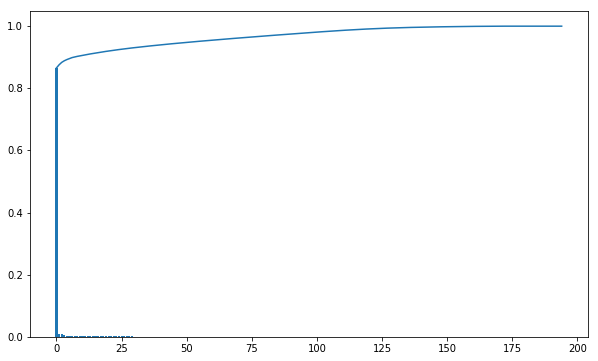

In [495]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(comps, vals)
ax.plot(comps, cumvals)

In [504]:
cumvals

array([ 0.86569181,  0.87561688,  0.88340034,  0.88861118,  0.89250604,
        0.89581018,  0.89888391,  0.90095083,  0.90278217,  0.90442227,
        0.90604751,  0.90762612,  0.90918911,  0.91064833,  0.91206198,
        0.91345907,  0.91482863,  0.91619021,  0.91750037,  0.91879379,
        0.92002909,  0.92124128,  0.92241565,  0.92357839,  0.92470317,
        0.9257982 ,  0.92688452,  0.92793731,  0.92894887,  0.92993758,
        0.93090155,  0.93184879,  0.93277949,  0.93370042,  0.93461543,
        0.9355152 ,  0.93640315,  0.93728243,  0.93815322,  0.93900539,
        0.93984033,  0.9406718 ,  0.94149479,  0.94231513,  0.94312504,
        0.9439151 ,  0.94470137,  0.94548187,  0.94625117,  0.94701742,
        0.94777143,  0.94852107,  0.94926303,  0.95000297,  0.95073798,
        0.95147191,  0.95219639,  0.95291207,  0.95362663,  0.95433349,
        0.95503757,  0.95573729,  0.95643291,  0.95712626,  0.95781665,
        0.95850526,  0.95918865,  0.95986638,  0.96054245,  0.96

In [502]:
var_max_vals = [0.90,0.95,0.99]
for v in var_max_vals:
    print(np.argwhere(cumvals > v)[0]+1)

[8]
[54]
[119]


In [503]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=54)
df_pca = pca.fit_transform(df_scaled)

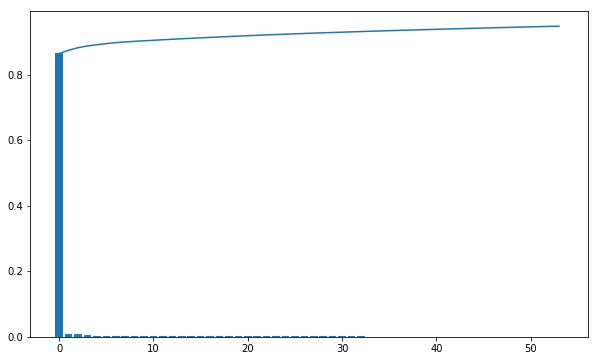

In [505]:
num_components=len(pca.explained_variance_ratio_)
comps = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(comps, vals)
ax.plot(comps, cumvals)

### Discussion 2.2: Perform Dimensionality Reduction

We see that the first component explains about 86% of all variance. 

We also sett that we cover 
- 90% with 8 components,
- 95% with 54 components, and 
- 99% with 119 components

Re-running PCA with 54 components to target 95% variance, reducing the total number of components from 195 to 54. 

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [35]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def interpret_component(pca_object, component, feature_names, num_weights):
    '''
    Will print the weights for the i'th principal components
    
    INPUTS
    pca_object: the fitted pca_object
    component: which component to plot (integer)
    feature_names: list of feature names (e.g. df.columns)
    num_weights: number of weights to plot
    '''
    comps = pd.DataFrame(list(zip(pca_object.components_[component], feature_names)), columns=["pca_value", "feature"])
    comps = comps.iloc[(-comps["pca_value"].abs()).argsort()]
    comps = comps[:num_weights]
    
    plt.subplots(figsize=(15,5))
    g = sns.barplot(x=comps["feature"], y=comps["pca_value"], data=comps, palette="viridis")
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.ylim(-1,1) 
    plt.tight_layout()
    plt.show(g)
    print(comps)

In [633]:
feature_names = list(df_clean.columns)




---------- Component 0----------


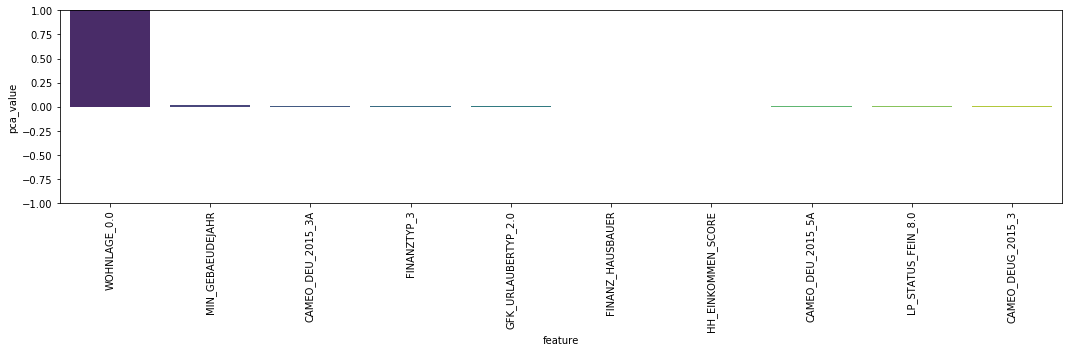

     pca_value              feature
182   0.999655         WOHNLAGE_0.0
35    0.021827     MIN_GEBAEUDEJAHR
147   0.008512    CAMEO_DEU_2015_3A
72    0.004809          FINANZTYP_3
77    0.002933  GFK_URLAUBERTYP_2.0
7    -0.002885     FINANZ_HAUSBAUER
29   -0.002381   HH_EINKOMMEN_SCORE
156   0.002380    CAMEO_DEU_2015_5A
106   0.002340   LP_STATUS_FEIN_8.0
131   0.002295    CAMEO_DEUG_2015_3



---------- Component 1----------


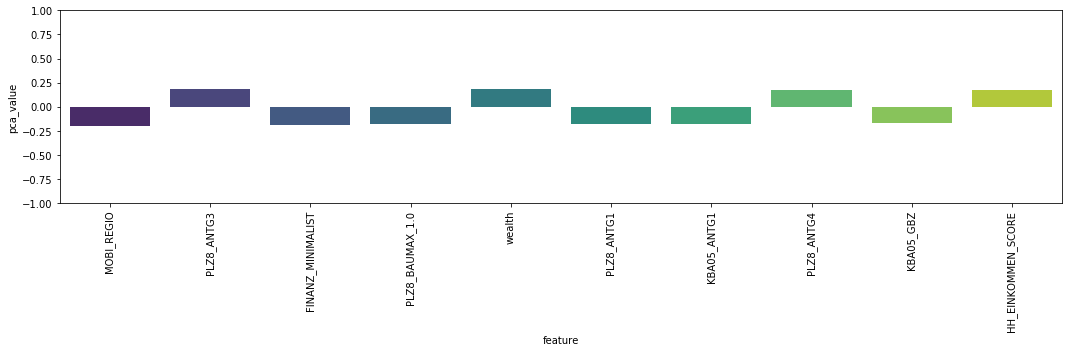

     pca_value             feature
47   -0.195935          MOBI_REGIO
53    0.185876          PLZ8_ANTG3
2    -0.185843   FINANZ_MINIMALIST
190  -0.184279     PLZ8_BAUMAX_1.0
62    0.183923              wealth
51   -0.183657          PLZ8_ANTG1
37   -0.179477         KBA05_ANTG1
54    0.177886          PLZ8_ANTG4
41   -0.174678           KBA05_GBZ
29    0.171966  HH_EINKOMMEN_SCORE



---------- Component 2----------


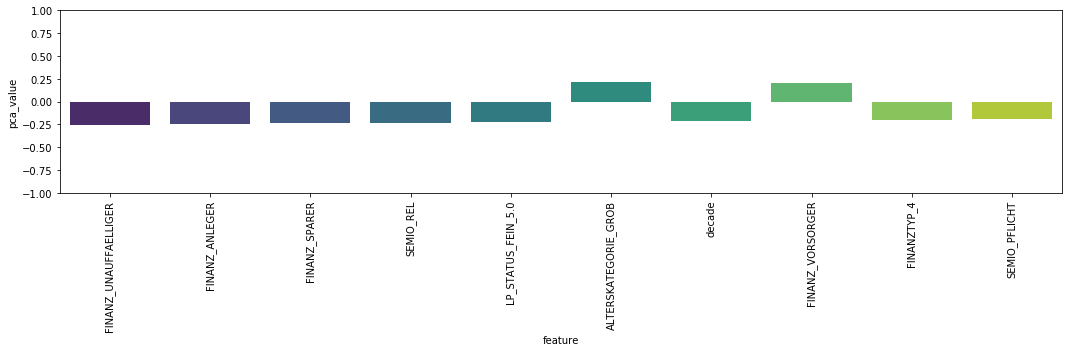

     pca_value                feature
6    -0.256289  FINANZ_UNAUFFAELLIGER
5    -0.242040         FINANZ_ANLEGER
3    -0.235039          FINANZ_SPARER
13   -0.234531              SEMIO_REL
103  -0.224408     LP_STATUS_FEIN_5.0
0     0.218037   ALTERSKATEGORIE_GROB
60   -0.209598                 decade
4     0.207083       FINANZ_VORSORGER
73   -0.195918            FINANZTYP_4
23   -0.186655          SEMIO_PFLICHT


In [636]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

for c in range(0,3):
    print("\n\n\n---------- Component {}----------".format(c))
    interpret_component(pca, c, feature_names, 10)

### Discussion 2.3.1: Interpret Principal Components

First of all, we see that `WOHNLAGE_0.0` has an extremely dominant weight of the first component, which again has a very dominant weight. Wohnlage equals neightbourhood quality = "no score calculated", which is not very informative. 

Will try to remove this column and rerun the the scaler, imputer, and PCA.

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

##### Removing "WOHNLAGE" and re-perform PCA

In [12]:
wohnlage = ["WOHNLAGE_0.0", 
            "WOHNLAGE_1.0", 
            "WOHNLAGE_2.0",
            "WOHNLAGE_3.0",
            "WOHNLAGE_4.0",
            "WOHNLAGE_5.0",
            "WOHNLAGE_7.0",
            "WOHNLAGE_8.0"]

df_clean_wo = df_clean.drop(columns=wohnlage, axis=1)

scaler_wo = StandardScaler().fit(df_clean_wo.dropna())
imp_mean_wo = SimpleImputer(missing_values=np.nan, strategy='mean').fit(df_clean_wo)
df_imp_wo = imp_mean_wo.transform(df_clean_wo)
df_scaled_wo = scaler_wo.transform(df_imp_wo)

In [641]:
pca_wo = PCA()
df_pca_wo = pca_wo.fit_transform(df_scaled_wo)

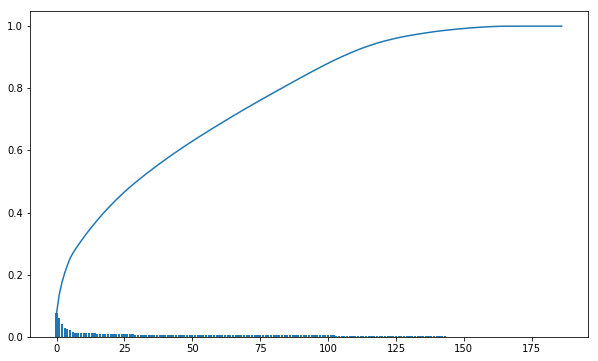

In [642]:
num_components_wo=len(pca_wo.explained_variance_ratio_)
comps_wo = np.arange(num_components_wo)
vals_wo = pca_wo.explained_variance_ratio_
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals_wo = np.cumsum(vals_wo)
ax.bar(comps_wo, vals_wo)
ax.plot(comps_wo, cumvals_wo)

In [644]:
var_max_vals = [0.90,0.95,0.99]
for v in var_max_vals:
    print(np.argwhere(cumvals_wo > v)[0]+1)

[106]
[121]
[148]


In [13]:
pca_wo = PCA(n_components=121)
df_pca_wo = pca_wo.fit_transform(df_scaled_wo)




---------- Component 1----------


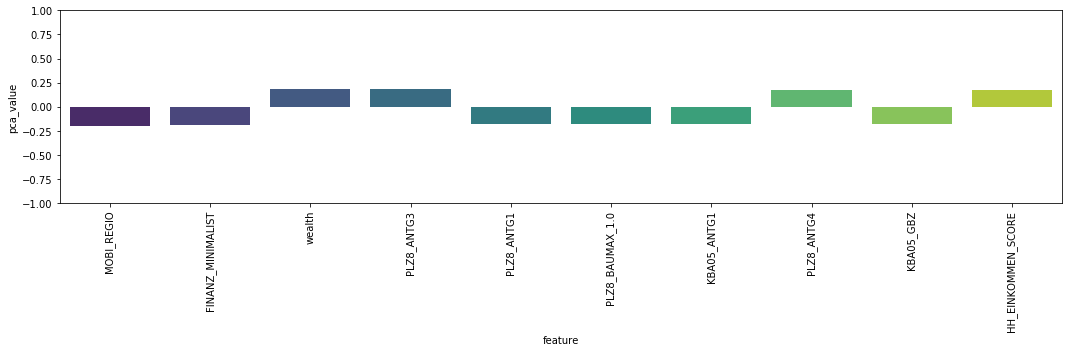

     pca_value             feature
47   -0.197127          MOBI_REGIO
2    -0.191254   FINANZ_MINIMALIST
62    0.186283              wealth
53    0.185561          PLZ8_ANTG3
51   -0.184375          PLZ8_ANTG1
182  -0.184240     PLZ8_BAUMAX_1.0
37   -0.181170         KBA05_ANTG1
54    0.177848          PLZ8_ANTG4
41   -0.175537           KBA05_GBZ
29    0.175436  HH_EINKOMMEN_SCORE



---------- Component 2----------


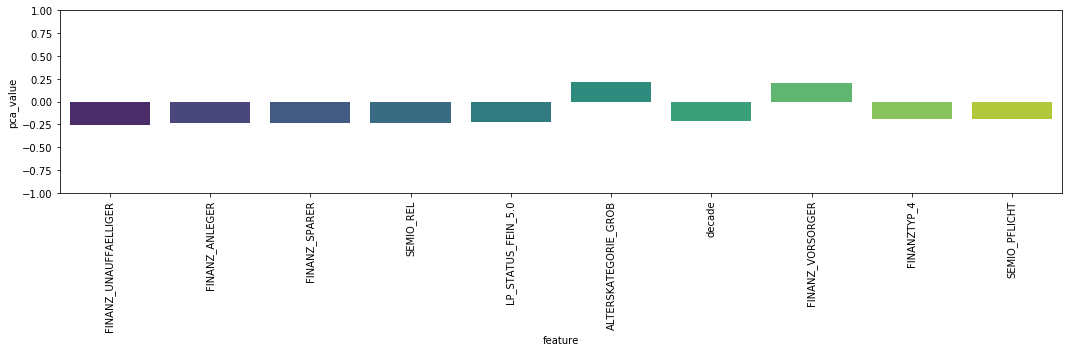

     pca_value                feature
6    -0.256077  FINANZ_UNAUFFAELLIGER
5    -0.238470         FINANZ_ANLEGER
3    -0.232205          FINANZ_SPARER
13   -0.231999              SEMIO_REL
103  -0.221936     LP_STATUS_FEIN_5.0
0     0.216654   ALTERSKATEGORIE_GROB
60   -0.209194                 decade
4     0.205720       FINANZ_VORSORGER
73   -0.192180            FINANZTYP_4
23   -0.185002          SEMIO_PFLICHT



---------- Component 3----------


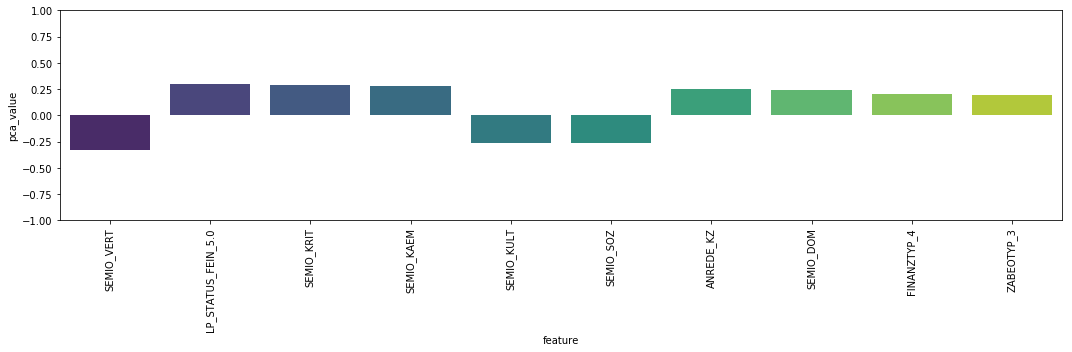

     pca_value             feature
15   -0.326042          SEMIO_VERT
103   0.295963  LP_STATUS_FEIN_5.0
20    0.292629          SEMIO_KRIT
22    0.276719          SEMIO_KAEM
18   -0.266416          SEMIO_KULT
11   -0.259411           SEMIO_SOZ
1     0.249740           ANREDE_KZ
21    0.244846           SEMIO_DOM
73    0.207973         FINANZTYP_4
118   0.192361          ZABEOTYP_3


In [36]:
feature_names_wo = list(df_clean_wo.columns)
for c in range(0,3):
    print("\n\n\n---------- Component {}----------".format(c+1))
    interpret_component(pca_wo, c, feature_names_wo, 10)

In [33]:
pca_wo.explained_variance_ratio_[:3].sum()

0.17546380383200408

### Discussion 2.3.2: Interpret Principal Components

After removing `WOHNLAGE_X`-columns, we see a differnt pattern in the components. 
First of all, the variance is more evenly distributed amongst the components. This does not necessarily prove that removing the `WOHNLAGE_X`-columns was correct, but I feel safe to assume that neighborhood quality is not the only dominant feature of a large population. 

We have also reduced number of features from 195 to 121.

Investigating the first 3 components:

**Component 1** seems to be weighting area, movement, and location, in addition to wealth/household income. Less dense areas have an opposite direction than more densely populated areas and wealth. 

**Component 2** seems to be weighting financial orientation. I interpret `FINANZ_VORSORGER` to be somewhat financial risk averse, and this is seemingly also connected to `ALTERSKATEGORIE_GROB`. The other variables correlate negatively and consist of other financial orientations and higher status. 

**Component 3** This component seems to be weighting personal traits. We see that the following personality traits have a positive correlation
- `SEMIO_VERT` (dreamful)
- `SEMIO_KULT` (cultural minded)
- `SEMIO_SOZ` (socially-minded)

Interestingly, the following have an opposite correlation with the above: 
- `SEMIO_KRIT` (critical minded)
- `SEMIO_KAEM` (combatitive mindset)
- `SEMIO_DOM` (dominant-minded)
in addition to the following
- `LP_STATUS_FEIN_5.0` (minimalistic high-income earners)
- `ZABEOTYP_3` (price-driven energy consumption)

To generalize, component 3 seems to summarize generally "open-minded"/"cultural" personality traits vs critical/less-open personaility traits - interesting!

**NB!** These three components only explain 17.5% of the total variance. 

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [46]:
# Over a number of different cluster counts...
scree = []
    
for k in range(2,20):
    print("\n\n-------- K = {} --------".format(k))
    start = time.time()
    # run k-means clustering on the data and...
    print("Progress: \n- creating model instance")
    KMM_model = KMeans(k)
    print("- fitting...")
    KMM_model.fit(df_pca_wo)
    
    # compute the average within-cluster distances.
    print("- fitting completed. Appending score")
    score=abs(KMM_model.score(df_pca_wo))
    end = time.time()
    scree.append(score)
    print("Results:\n- Score: {} \n- Time taken: {:.2f} seconds".format(score, end-start))



-------- K = 2 --------
Progress: 
- creating model instance
- fitting...
- fitting completed. Appending score
Results:
- Score: 143651992.8390151 
- Time taken: 105.56 seconds


-------- K = 3 --------
Progress: 
- creating model instance
- fitting...
- fitting completed. Appending score
Results:
- Score: 138140557.34465113 
- Time taken: 117.89 seconds


-------- K = 4 --------
Progress: 
- creating model instance
- fitting...
- fitting completed. Appending score
Results:
- Score: 133860612.05769843 
- Time taken: 131.39 seconds


-------- K = 5 --------
Progress: 
- creating model instance
- fitting...
- fitting completed. Appending score
Results:
- Score: 130842884.02665423 
- Time taken: 146.97 seconds


-------- K = 6 --------
Progress: 
- creating model instance
- fitting...
- fitting completed. Appending score
Results:
- Score: 128337705.31791289 
- Time taken: 186.44 seconds


-------- K = 7 --------
Progress: 
- creating model instance
- fitting...
- fitting completed. Appe

In [55]:
df_scree = pd.DataFrame(scree)
df_scree.index = (range(2,20))
df_scree.to_csv('scree.csv')

In [53]:
df_scree

,0
2,1.436520e+08
3,1.381406e+08
4,1.338606e+08
5,1.308429e+08
6,1.283377e+08
7,1.266735e+08
8,1.251968e+08
9,1.238994e+08
10,1.228704e+08
11,1.216743e+08


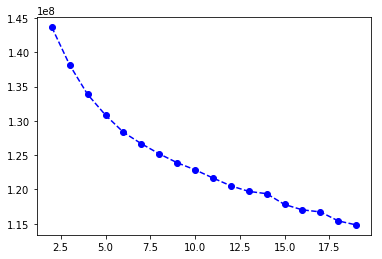

In [54]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(df_scree, linestyle='--', marker='o', color='b')

In [14]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
KMM_model = KMeans(16)
KMM_model.fit(df_pca_wo)

score=abs(KMM_model.score(df_pca_wo))
print("Refitting KMeans with 16 clusters gives score of: {}".format(score))

Refitting KMeans with 16 clusters gives score of: 117277378.67370354


### Discussion 3.1: Apply Clustering to General Population

We've ran Kmeans clustering over the reduced dataset for 2-19 clusters. Inspecting the absolute value of the error/score of each model shows shrinking score, but this reduction is starting to diminish around 16 cluster. 

Refitted the Kmeans model with 16 clsuters based on this result. 

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [20]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ";")
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [21]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#creating a new version of clean_data as we want the function to delete the same columns as the demographics data
def clean_data_customer(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:
    df:        Demographics DataFrame
            
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    print("initializing...")
    
    dec_vals = []
    movement_vals = []
    wealth_vals = []
    life_stage_vals = []
    
    praegende_jugendjahre_dict = {
        1: [40, 0], 
        2: [40, 1], 
        3: [50, 0], 
        4: [50, 1], 
        5: [60, 0], 
        6: [60, 1],
        7: [60, 1],
        8: [70, 0], 
        9: [70, 1], 
        10: [80, 0], 
        11: [80, 1], 
        12: [80, 0], 
        13: [80, 1], 
        14: [90, 0], 
        15: [90, 1]
    }
    
    print("initializing feature info...")
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ";")
    feat_info["NA_int"] = feat_info.loc[:,"missing_or_unknown"].apply(lambda x : string_to_list(x))
    feat_info.drop('missing_or_unknown', axis = 1, inplace=True)
    feat_info.set_index('attribute', inplace=True)
    
    
    # convert missing value codes into NaNs, ...
    print("converting to NaNs...")
    for column in df.columns:
        df[column].replace(feat_info.loc[column, "NA_int"], np.NaN, inplace=True)
    
    # remove columns based on demographics data's missing values ...
    print("removing same columns as with demographics dataset...")
    cols_to_drop = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    
    # select, re-encode, and engineer column values.
    print("initializing new columns...")
    df["decade"] = None
    df["dom_movement"] = None
    df["wealth"] = None
    df["life_stage"] = None
    
    print("re-encoding OST_WEST_KZ...")
    df.loc[:,"OST_WEST_KZ"] = df.loc[:,"OST_WEST_KZ"].dropna().apply(lambda x: 0 if x == "W" else 1)
    
    print("re-encoding PRAEGENDE_JUGENDJAHRE...")
    for v in df.loc[:,"PRAEGENDE_JUGENDJAHRE"]:
        try:
            dec_vals.append(praegende_jugendjahre_dict[v][0])
            movement_vals.append(praegende_jugendjahre_dict[v][1])
        except Exception as e:
            dec_vals.append(np.nan)
            movement_vals.append(np.nan)

    print("re-encoding CAMEO_INTL_2015...")
    for v in pd.to_numeric(df.loc[:,"CAMEO_INTL_2015"]):
        try: 
            wealth_vals.append(int(v/10))
            life_stage_vals.append(int(v%10))
        except Exception as e: 
            wealth_vals.append(np.nan)
            life_stage_vals.append(np.nan)

    print("writing re-encoded values...")
    df.loc[:,"wealth"] = wealth_vals
    df.loc[:,"life_stage"] = life_stage_vals
    df.loc[:,"decade"] = dec_vals
    df.loc[:,"dom_movement"] = movement_vals
    
    cols_encode = ['CJT_GESAMTTYP',
                   'FINANZTYP',
                   'GFK_URLAUBERTYP',
                   'LP_FAMILIE_FEIN',
                   'LP_STATUS_FEIN',
                   'NATIONALITAET_KZ',
                   'SHOPPER_TYP',
                   'ZABEOTYP',
                   'GEBAEUDETYP',
                   'CAMEO_DEUG_2015',
                   'CAMEO_DEU_2015',
                   'WOHNLAGE',
                   'PLZ8_BAUMAX']
    
    print("creating dummies...")
    df = pd.get_dummies(df, prefix=cols_encode, columns=cols_encode)
    
    cols_to_drop.extend(['LP_FAMILIE_GROB',
                         'LP_STATUS_GROB',
                         'LP_LEBENSPHASE_FEIN',
                         'LP_LEBENSPHASE_GROB',
                         'PRAEGENDE_JUGENDJAHRE',
                         'CAMEO_INTL_2015'])
    
    print("dropping columns...")
    df.drop(columns=cols_to_drop, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df
    

In [22]:
#preprocessing
df_cust_clean = clean_data_customer(customers)
df_cust_clean.shape[1] == df_clean.shape[1]

initializing...
initializing feature info...
converting to NaNs...
removing same columns as with demographics dataset...
initializing new columns...
re-encoding OST_WEST_KZ...
re-encoding PRAEGENDE_JUGENDJAHRE...
re-encoding CAMEO_INTL_2015...
writing re-encoded values...
creating dummies...
dropping columns...


False

In [34]:
print("Columns in demographics dataset, not in customer dataset:\n{}".format(list(set(df_clean.columns)-set(df_cust_clean.columns))))
print("\nColumns in customer dataset, not in demographics dataset:\n{}".format(list(set(df_cust_clean.columns)-set(df_clean.columns))))

Columns in demographics dataset, not in customer dataset:
['GEBAEUDETYP_5.0']

Columns in customer dataset, not in demographics dataset:
[]


In [35]:
#In the customer set there are no values for 'GEBAEUDETYP' equal to 5.0. 
#therefore, this column was never created with "create dummies". Creating this mannually with values=0
df_cust_clean.loc[:,'GEBAEUDETYP_5.0'] = 0

In [37]:
df_cust_clean.shape[1] == df_clean.shape[1]

True

In [40]:
#feature scaling and PCA
df_cust_clean_wo = df_cust_clean.drop(columns=wohnlage, axis=1)

In [42]:
df_cust_imp = imp_mean_wo.transform(df_cust_clean_wo)
df_cust_scaled_wo = scaler_wo.transform(df_cust_imp)

In [43]:
df_cust_pca_wo = pca_wo.transform(df_cust_scaled_wo)

In [48]:
#predictions
demo_preds = KMM_model.predict(df_pca_wo)
cust_preds = KMM_model.predict(df_cust_pca_wo)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [49]:
#creating a dataframe with prediction results:
df_demo_preds = pd.DataFrame(demo_preds, columns=['Demographic Predictions'])
df_cust_preds = pd.DataFrame(cust_preds, columns=['Customer Data Predictions'])

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
index = df_demo_preds['Demographic Predictions'].value_counts().sort_index().index
col_demo = df_demo_preds['Demographic Predictions'].value_counts().sort_index().values  / len(df_demo_preds)
col_cust = df_cust_preds['Customer Data Predictions'].value_counts().sort_index().values  / len(df_cust_preds)

df_clusters = pd.DataFrame(zip(index, col_demo, col_cust), columns = ["Cluster","Demographic", "Customers"], index = index)
df_clusters[["Demographic", "Customers"]] *= 100

In [86]:
df_clusters_melted = df_clusters.melt("Cluster", var_name="DataSet",value_name="Portion in cluster")

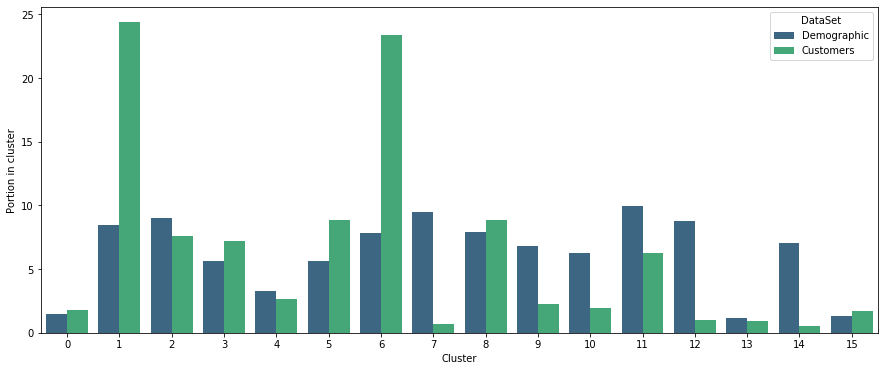

In [96]:
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x = 'Cluster', y = "Portion in cluster", data = df_clusters_melted, hue = "DataSet", palette="viridis")

In [242]:
#centers = scaler_wo.inverse_transform(pca_wo.inverse_transform(KMM_model.cluster_centers_))
centers = pca_wo.inverse_transform(KMM_model.cluster_centers_)
df_clusters_inverse = pd.DataFrame(centers, columns=df_clean_wo.columns)

In [236]:
df_clusters_inverse.to_csv("df_clusters_inverse.csv")

In [233]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
def plot_features_inverse(df, cluster, features_to_compare=20):
    """
    plots the x most important features of the cluster based on highest absolute value
    
    INPUTS
    df: dataframe with inverted centroids with rows = clusters, columns = feature names
    cluster: which cluster to plot
    features_to_compare = number of features to plot
    OUTPUTS
    returns the list of features
    """
    plot=df.loc[cluster,abs(df.loc[cluster,:]).sort_values(ascending=False)[:features_to_compare].index].sort_values()
    sns.barplot(x=plot.values, y=plot.index, palette="viridis")
    plt.tight_layout()
    plt.show()
    
    return plot.index

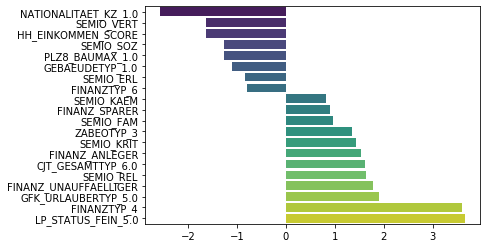

In [177]:
cluster_feats_1 = plot_features_inverse(df_clusters_inverse,1)

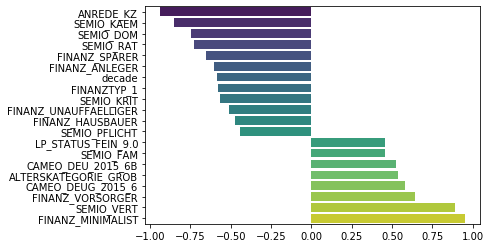

In [178]:
cluster_feats_6 = plot_features_inverse(df_clusters_inverse,6)

In [192]:
print("Important features of Company's Customers:")
for f in (cluster_feats_6.append(cluster_feats_1)).unique().sort_values():
    print("- {}".format(f))

Important features of Company's Customers:
- ALTERSKATEGORIE_GROB
- ANREDE_KZ
- CAMEO_DEUG_2015_6
- CAMEO_DEU_2015_6B
- CJT_GESAMTTYP_6.0
- FINANZTYP_1
- FINANZTYP_4
- FINANZTYP_6
- FINANZ_ANLEGER
- FINANZ_HAUSBAUER
- FINANZ_MINIMALIST
- FINANZ_SPARER
- FINANZ_UNAUFFAELLIGER
- FINANZ_VORSORGER
- GEBAEUDETYP_1.0
- GFK_URLAUBERTYP_5.0
- HH_EINKOMMEN_SCORE
- LP_STATUS_FEIN_5.0
- LP_STATUS_FEIN_9.0
- NATIONALITAET_KZ_1.0
- PLZ8_BAUMAX_1.0
- SEMIO_DOM
- SEMIO_ERL
- SEMIO_FAM
- SEMIO_KAEM
- SEMIO_KRIT
- SEMIO_PFLICHT
- SEMIO_RAT
- SEMIO_REL
- SEMIO_SOZ
- SEMIO_VERT
- ZABEOTYP_3
- decade



----- Cluster 7 -----


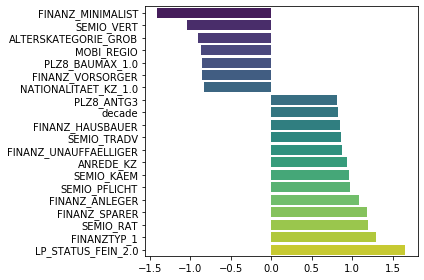


----- Cluster 14 -----


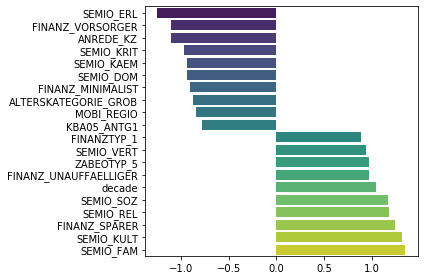

In [243]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
feats = []
for f in [7,14]:
    print("\n----- Cluster {} -----".format(f))
    cluster_feats = plot_features_inverse(df_clusters_inverse,f,20)
    feats.extend(list(cluster_feats))

In [231]:
print("Features with little importance for Company's Customers:")

for f in sorted(set(feats)):
    print("- {}".format(f))

Features with little importance for Company's Customers:
- ALTERSKATEGORIE_GROB
- ANREDE_KZ
- FINANZTYP_1
- FINANZ_ANLEGER
- FINANZ_HAUSBAUER
- FINANZ_MINIMALIST
- FINANZ_SPARER
- FINANZ_UNAUFFAELLIGER
- FINANZ_VORSORGER
- KBA05_ANTG1
- LP_STATUS_FEIN_2.0
- LP_STATUS_FEIN_5.0
- MOBI_REGIO
- NATIONALITAET_KZ_1.0
- PLZ8_ANTG3
- PLZ8_BAUMAX_1.0
- RETOURTYP_BK_S
- SEMIO_DOM
- SEMIO_ERL
- SEMIO_FAM
- SEMIO_KAEM
- SEMIO_KRIT
- SEMIO_KULT
- SEMIO_PFLICHT
- SEMIO_RAT
- SEMIO_REL
- SEMIO_SOZ
- SEMIO_TRADV
- SEMIO_VERT
- ZABEOTYP_3
- ZABEOTYP_5
- decade


### Discussion 3.3: Compare Customer Data to Demographics Data

#### Overrepresented clusters in Customer Data
There are specifically two clusters that are overrepresented in the Customer data vs the overall demographic data: Clusters 1 and 6. 

**Cluster 1:**
- Positive correlation with
    - Minimalistic, high-income earners
    - Financially stable
- Negative correlation with 
    - German-souding names
    - Dreamy personality traits
    - Socially minded personality traits
If I were to conclude on this, I would recommend the Company to target high-earning and financially stable areas, possibly areas/populations with more non-German-sounding names (would recommend to double-check the ethics on that), in addition to having a low score on dreamy and socially minded personality types.

**Cluster 6:**
- Positive correlation with
    - Dreamy personality traits
    - Financial minimalistic, but stable
    - Low-consumption middleclass
- Negative correlation with
    - Combatitive, dominant and rational personailty traits
    - Males
If I were to conclude based on this, I would recommend targeting female customers that scoring higher on "dreaming" personality traits in the low-consumption middleclass, and simultaneously having less "hostile" personality traits. 


#### Overrepresented clusters in Demographics Data
In addition, there are three clusters of which are overrepresented in the demographic data compared to the Customer data. Here, the recommendation is the opposite: These would be customer groups to avoid

**Cluster 7**
- Positive correlation with 
    - low income and
    - low financial interest
- Negative correlation with
    - Dreamy personality traints
    - Financial minimalists
To generalize/conclude on this information, I would suggest the company to avoid low-income customers and customers with low financial interst, while at the same time being less "dreamy". 

**Cluster 14**
- Positive correlation with
    - Cultural and family oriented personality traits
    - focused on financial savings
- Negative correlation with
    - Event oriented
To conclude on this, avoid customers that are family oriented, focusing on savings, and also less out-going. 


(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.